In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter
import pickle as pkl
import random
import pdb
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(134)

PAD_IDX = 0
UNK_IDX = 1
BATCH_SIZE = 64

In [ ]:
#load fast text word vectors
fasttext_dir = 'wiki-news-300d-1M.vec'
words_to_load = 50000
emb_size = 300

with open(fasttext_dir, encoding='utf8') as f:
    loaded_embeddings = np.zeros((words_to_load + 2, emb_size))
    words = {}
    idx2words = {}
    ordered_words = []
    idx2words[PAD_IDX] = '<pad>'
    idx2words[UNK_IDX] = '<unk>'
    words['<pad>'] = PAD_IDX
    words['<unk>'] = UNK_IDX
    for i, line in enumerate(f):
        if i >= words_to_load: 
            break
        s = line.split()
        loaded_embeddings[i+2, :] = np.asarray(s[1:])
        words[s[0]] = i+2
        idx2words[i+2] = s[0]
        ordered_words.append(s[0])
        
loaded_embeddings = torch.from_numpy(loaded_embeddings)

In [2]:
idx2words = pkl.load(open("wiki-news-300d-idx2words.vec", "rb"))
words = pkl.load(open("wiki-news-300d-words.vec", "rb"))
loaded_embeddings = pkl.load(open("wiki-news-300d-50000.vec", "rb"))
loaded_embeddings = torch.from_numpy(loaded_embeddings)

In [3]:
#test vectors
print(words['potato'])
print(idx2words[words['potato']])

12978
potato


In [41]:
#trasfer the label to integer, entailment = 2, contradiction = 0, neutral = 1
label2int = {'entailment':2, 'contradiction': 0, 'neutral': 1}

#read part of the dataset
train_num = 100000
val_num = 1000

def read_data(data_dir,data_num):
    sentence = []
    label = []
    with open(data_dir, encoding='utf8') as f:
        for i,line in enumerate(f):
            if i == 0:
                continue
            if i > data_num:
                break
            line = line.strip('\n')
            sentence_sample = []
            sentence_sample.append(line.split('\t')[0].split(' '))
            sentence_sample.append(line.split('\t')[1].split(' '))
            sentence.append(sentence_sample)
            label.append(label2int[line.split('\t')[2]])
    return sentence, label

train_sentence,train_label = read_data('snli_train.tsv',train_num)
val_sentence,val_label =read_data('snli_val.tsv',val_num)

In [32]:
#decide the max_sentence_length
len_list = []
for i in train_sentence:
    len_list.append(len(i[0]))
    len_list.append(len(i[1]))
print(np.percentile(np.array(len_list), 99))

30.0


In [19]:
MAX_SENTENCE_LEN = 30
class SNLIDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, sentence, target, words):
        """
        @param data_list: list with each component consists of two lists: sentence1 and sentence2
        @param target_list: list of targets

        """
        self.data_list = sentence
        self.target_list = target
        assert (len(self.data_list) == len(self.target_list))
        self.word2id = words

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        word_idx1 = [self.word2id[c] if c in self.word2id.keys() else UNK_IDX  for c in self.data_list[key][0][:MAX_SENTENCE_LEN]]
        word_idx2 = [self.word2id[c] if c in self.word2id.keys() else UNK_IDX  for c in self.data_list[key][1][:MAX_SENTENCE_LEN]]
        label = self.target_list[key]
        return [[word_idx1, word_idx2], [len(word_idx1),len(word_idx2)], label]

def collate_func(batch):
    """
   Do the padding and sort the two sentences seperately, return the sorted sentences and unsort index
    """
    x1_list = []
    x2_list = []
    label_list = []
    length_list = [] 
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])

    # padding
    for datum in batch:
        padded_vec1 = np.pad(np.array(datum[0][0]),
                                pad_width=((0,MAX_SENTENCE_LEN-datum[1][0])),
                                mode="constant", constant_values=PAD_IDX)
        x1_list.append(padded_vec1)
        padded_vec2 = np.pad(np.array(datum[0][1]),
                                pad_width=((0,MAX_SENTENCE_LEN-datum[1][1])),
                                mode="constant", constant_values=PAD_IDX)
        x2_list.append(padded_vec2)
        
    #sort seperately
    x1_len,x2_len = zip(*length_list)
    #x1
    x1_sort_idx = np.argsort(x1_len)[::-1]
    x1_list = np.array(x1_list)[x1_sort_idx]
    x1_len = np.array(x1_len)[x1_sort_idx]
    
    #x2
    x2_sort_idx = np.argsort(x2_len)[::-1]
    x2_list =  np.array(x2_list)[x2_sort_idx]
    x2_len = np.array(x2_len)[x2_sort_idx]
    
    #find unsort index
    x1_unsort_idx = np.argsort(x1_sort_idx)
    x2_unsort_idx = np.argsort(x2_sort_idx)
    return [torch.from_numpy(x1_list), torch.from_numpy(x2_list), torch.LongTensor(x1_len),torch.LongTensor(x2_len), x1_unsort_idx, x2_unsort_idx, torch.LongTensor(label_list)]


In [42]:
# Build train and valid dataloaders


train_dataset = SNLIDataset(train_sentence, train_label, words)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=collate_func,
                                           shuffle=True)

val_dataset = SNLIDataset(val_sentence, val_label, words)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=collate_func,
                                           shuffle=False)



# RNN

In [3]:
#test cuda avalibility
if torch.cuda.is_available and torch.has_cudnn:
    print("CUDA available!")
    device = torch.device('cuda')
else:
    print("Warning! Only CPU!")
    device = torch.device("cpu")

CUDA available!


In [36]:
#parameters
hidden_size = 200
interm_size = 100
learning_rate = 5e-4
num_epochs = 15 # number epoch to train

In [4]:
class RNN(nn.Module):
    def __init__(self, word_embedding, hidden_size, interm_size, num_layers, num_classes, interact, dropout):
        # RNN Accepts the following hyperparams:
        # word_embedding: pretrained embedding vectors
        # hidden_size: Hidden Size of layer in RNN
        # num_layers: number of layers in RNN, 1 here
        # num_classes: number of output classes, 3 here
        super(RNN, self).__init__()
        emb_size = word_embedding.shape[1]
        self.num_layers, self.hidden_size, self.dropout = num_layers, hidden_size, dropout
        self.embedding = nn.Embedding.from_pretrained(word_embedding, freeze = False)
        self.rnn = nn.GRU(input_size= emb_size, hidden_size = hidden_size, num_layers = num_layers , batch_first=True, bidirectional  = True)
        if interact == 'concat':
            self.fc1 = nn.Linear(hidden_size *4, interm_size)
        elif interact == 'mul':
            self.fc1 = nn.Linear(hidden_size *2, interm_size)
        if dropout != 0:
            self.dropout_layer = nn.Dropout(p = dropout)
        self.fc2 = nn.Linear(interm_size, num_classes)
        self.interact_option = interact

    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers * num_directions, batch_size, hidden_size)
        x1_hidden = torch.randn(self.num_layers * 2, batch_size, self.hidden_size).float().to(device)
        x2_hidden = torch.randn(self.num_layers * 2, batch_size, self.hidden_size).float().to(device)
        return x1_hidden, x2_hidden

    def forward(self, x1,x2, x1_lengths, x2_lengths, x1_unsort_idx, x2_unsort_idx):
        # reset hidden state
        assert (x1.size() == x2.size())
 
        batch_size, seq_len = x1.size()
        self.x1_hidden, self.x2_hidden = self.init_hidden(batch_size)
        # get embedding of scentences
        embed1 = self.embedding(x1)
        #detach the frozen word embeddings except the <unk> and <pad>
        #print(self.embedding(torch.tensor([3]).cuda())[0][:7])
        #print(self.embedding(torch.tensor([1]).cuda())[0][:7])
        #build mask
#         mask1 = torch.ones(embed1.shape)
#         for index1 in range(len(x1)):
#             for index2 in range(len(x1[index1])):
#                 if x1[index1][index2]==PAD_IDX or x1[index1][index2]==UNK_IDX:
#                     mask1[index1][index2].zero_()
#         mask1 = mask1.to(device)
        mask1 = (x1 == 1).type(torch.cuda.FloatTensor)
        mask1 = mask1.unsqueeze(2).repeat(1, 1, 300)
        #print(mask1)
        embed1 = mask1 * embed1.float() + (1-mask1) * (embed1.clone().detach().float())
        
        embed2 = self.embedding(x2)
#         mask2 = torch.ones(embed2.shape)
#         for index1 in range(len(x2)):
#             for index2 in range(len(x2[index1])):
#                 if x2[index1][index2]==PAD_IDX or x2[index1][index2]==UNK_IDX:
#                     mask2[index1][index2].zero_()
#         mask2 = mask2.to(device)
        mask2 = (x2 == 1).type(torch.cuda.FloatTensor)
        mask2 = mask2.unsqueeze(2).repeat(1, 1, 300)
        embed2 = mask2 * embed2.float() + (1-mask2) * (embed2.clone().detach().float())

        # pack padded sequence, descending order
        embed1 = torch.nn.utils.rnn.pack_padded_sequence(embed1, x1_lengths.cpu().numpy(), batch_first=True)
        embed2 = torch.nn.utils.rnn.pack_padded_sequence(embed2, x2_lengths.cpu().numpy(), batch_first=True)

        # fprop though RNN      
        _, self.x1_hidden = self.rnn(embed1, self.x1_hidden)
        _, self.x2_hidden = self.rnn(embed2, self.x2_hidden)
    
        #unsort hidden states, hidden: seq_len, batch, num_directions * hidden_size
        self.x1_hidden[0] = self.x1_hidden[0][x1_unsort_idx]
        self.x1_hidden[1] = self.x1_hidden[1][x1_unsort_idx]
        self.x2_hidden[0] = self.x2_hidden[0][x2_unsort_idx]
        self.x2_hidden[1] = self.x2_hidden[1][x2_unsort_idx]
        self.x1_hidden = torch.cat((self.x1_hidden[0], self.x1_hidden[1]),1)
        self.x2_hidden = torch.cat((self.x2_hidden[0], self.x2_hidden[1]),1)

        #interact
        if self.interact_option == 'concat':
            #concat
            rnn_out = torch.cat((self.x1_hidden,self.x2_hidden), 1)
        elif self.interact_option == 'mul':
            #element-wise mul
            rnn_out = self.x1_hidden * self.x2_hidden

        #pass through 2 full connected layers
        interm = self.fc1(rnn_out)
        interm = F.relu(interm)
        if self.dropout != 0:
            interm = self.dropout_layer(interm)
        logits = self.fc2(interm)
        logits = F.log_softmax(logits,dim = 1)
        
        return logits


In [8]:
def test_model(loader, model, criterion):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    loss = 0
    model.eval()
    for x1,x2,x1_len,x2_len, x1_unsort_idx, x2_unsort_idx, labels in loader:
        x1_batch,x2_batch, x1_lengths_batch, x2_lengths_batch, x1_unsort_idx_batch, x2_unsort_idx_batch, label_batch =x1,x2,x1_len,x2_len,  x1_unsort_idx, x2_unsort_idx, labels
        x1_batch = x1_batch.long().to(device)
        x2_batch = x2_batch.long().to(device)
        x1_lengths_batch = x1_lengths_batch.to(device)
        x2_lengths_batch = x2_lengths_batch.to(device)
        label_batch = label_batch.to(device)
        outputs = model(x1_batch,x2_batch, x1_lengths_batch, x2_lengths_batch, x1_unsort_idx_batch, x2_unsort_idx_batch)
        predicted = outputs.max(1, keepdim=True)[1]

        loss += criterion(outputs, label_batch).item() *  labels.size(0)
        
        total += label_batch.size(0)
        correct += predicted.eq(label_batch.view_as(predicted)).sum().item()
    return loss/total,(100 * correct / total)

In [42]:

model = RNN(loaded_embeddings, hidden_size=hidden_size, interm_size=interm_size, num_layers=1, num_classes=3)
model = model.to(device)
val_acc_records = []
train_acc_records = []
val_loss_records = []
train_loss_records = []

torch.backends.cudnn.benchmark=True
# Criterion and Optimizer
criterion = torch.nn.NLLLoss()
#parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)

for epoch in range(num_epochs):
    loss_sum = 0.0
    total = 0
    for i, (x1,x2,x1_len,x2_len, x1_unsort_idx, x2_unsort_idx, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        x1 = x1.long().to(device)
        x2 = x2.long().to(device)
        x1_len = x1_len.to(device)
        x2_len = x2_len.to(device)
        labels = labels.to(device)
        outputs = model(x1, x2, x1_len, x2_len, x1_unsort_idx, x2_unsort_idx)

        loss = criterion(outputs, labels)
        
        loss_sum += loss.item() * labels.size(0)
        total += labels.size(0)
        # Backward and optimize
        loss.backward()        
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 300 == 0:
            # validate
            val_loss, val_acc = test_model(val_loader, model)
            train_loss, train_acc = test_model(train_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}, Traning Acc: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc, train_acc))
    val_loss, val_acc = test_model(val_loader, model)
    print('Epoch {} Finished! Val Loss: {}, Train Loss: {}'.format(epoch+1, val_loss, loss_sum/total))
    train_loss_records.append(loss_sum/total)
    train_acc_records.append(train_acc)
    val_loss_records.append(val_loss)
    val_acc_records.append(val_acc)

Epoch: [1/15], Step: [301/1563], Validation Acc: 54.1, Traning Acc: 54.695
Epoch: [1/15], Step: [601/1563], Validation Acc: 58.5, Traning Acc: 58.573
Epoch: [1/15], Step: [901/1563], Validation Acc: 58.1, Traning Acc: 59.012
Epoch: [1/15], Step: [1201/1563], Validation Acc: 60.1, Traning Acc: 60.369
Epoch: [1/15], Step: [1501/1563], Validation Acc: 60.2, Traning Acc: 61.396
Epoch 1 Finished! Val Loss: 0.8681819791793823, Train Loss: 0.8396371284866333
Epoch: [2/15], Step: [301/1563], Validation Acc: 62.5, Traning Acc: 62.355
Epoch: [2/15], Step: [601/1563], Validation Acc: 61.8, Traning Acc: 63.599
Epoch: [2/15], Step: [901/1563], Validation Acc: 63.5, Traning Acc: 64.761
Epoch: [2/15], Step: [1201/1563], Validation Acc: 64.4, Traning Acc: 65.142
Epoch: [2/15], Step: [1501/1563], Validation Acc: 66.1, Traning Acc: 66.571
Epoch 2 Finished! Val Loss: 0.7965222043991089, Train Loss: 0.7620153292655945
Epoch: [3/15], Step: [301/1563], Validation Acc: 66.5, Traning Acc: 67.002
Epoch: [3/15]

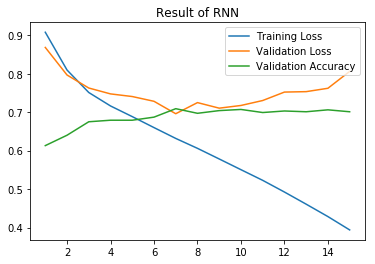

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline
#visualization
val_acc_records = [i/100 for i in val_acc_records]
epoches = np.arange(num_epochs) + 1
plt.plot(epoches,train_loss_records, label = "Training Loss")
plt.plot(epoches, val_loss_records, label = "Validation Loss")
plt.plot(epoches, val_acc_records, label = "Validation Accuracy")
plt.legend(loc='upper right')
plt.title('Result of RNN')
plt.show()

## Parameter Tuning (RNN)

### Size of Hidden Dimension

In [8]:
#parameters
hidden_size = 200
interm_size = 100
learning_rate = 5e-4
num_epochs = 15 # number epoch to train

In [22]:
words_to_load = 50000
emb_size = 300
def RNN_Tuning(train_sentence,train_label, val_sentence, val_label,words, loaded_embeddings, hidden_size, interm_size, interact = 'concat', weight_decay = 0, dropout = 0):
    train_dataset = SNLIDataset(train_sentence, train_label, words)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=BATCH_SIZE,
                                               collate_fn=collate_func,
                                               shuffle=True)

    val_dataset = SNLIDataset(val_sentence, val_label, words)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                               batch_size=BATCH_SIZE,
                                               collate_fn=collate_func,
                                               shuffle=False)
    model = RNN(loaded_embeddings, hidden_size=hidden_size, interm_size=interm_size, num_layers=1, num_classes=3, interact = interact, dropout = dropout)
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    #Count number of parameters, minus the num of frozen embedding vectors since we detach them manually
    num_params = sum([np.prod(p.size()) for p in model_parameters]) - emb_size * words_to_load
    model = model.to(device)
    val_acc_records = []
    train_acc_records = []
    val_loss_records = []
    train_loss_records = []

    torch.backends.cudnn.benchmark=True
    # Criterion and Optimizer
    criterion = torch.nn.NLLLoss()
    #parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Train the model
    total_step = len(train_loader)

    for epoch in range(num_epochs):
        loss_sum = 0.0
        total = 0
        for i, (x1,x2,x1_len,x2_len, x1_unsort_idx, x2_unsort_idx, labels) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            # Forward pass
            x1 = x1.long().to(device)
            x2 = x2.long().to(device)
            x1_len = x1_len.to(device)
            x2_len = x2_len.to(device)
            labels = labels.to(device)
            outputs = model(x1, x2, x1_len, x2_len, x1_unsort_idx, x2_unsort_idx)

            loss = criterion(outputs, labels)

            loss_sum += loss.item() * labels.size(0)
            total += labels.size(0)
            # Backward and optimize
            loss.backward()        
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 700 == 0:
                # validate
                val_loss, val_acc = test_model(val_loader, model, criterion)
                train_loss, train_acc = test_model(train_loader, model, criterion)
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}, Traning Acc: {}'.format(
                           epoch+1, num_epochs, i+1, len(train_loader), val_acc, train_acc))
        val_loss, val_acc = test_model(val_loader, model, criterion)
        print('Epoch {} Finished! Val Loss: {}, Train Loss: {}'.format(epoch+1, val_loss, loss_sum/total))
        train_loss_records.append(loss_sum/total)
        train_acc_records.append(train_acc)
        val_loss_records.append(val_loss)
        val_acc_records.append(val_acc)
    return val_acc_records,train_acc_records,val_loss_records,train_loss_records, num_params

In [32]:
val_acc_records_hidsize = {}
train_acc_records_hidsize = {}
val_loss_records_hidsize = {}
train_loss_records_hidsize = {}
num_params_records_hidsize = {}
for hidden_size in[100,200,300,400]:
    val_acc_records_hidsize[hidden_size],train_acc_records_hidsize[hidden_size],val_loss_records_hidsize[hidden_size],train_loss_records_hidsize[hidden_size], num_params_records_hidsize[hidden_size] \
        = RNN_Tuning(train_sentence,train_label, val_sentence, val_label,words, loaded_embeddings, hidden_size, interm_size)

Epoch: [1/15], Step: [701/1563], Validation Acc: 59.2, Traning Acc: 58.571
Epoch: [1/15], Step: [1401/1563], Validation Acc: 60.5, Traning Acc: 60.743
Epoch 1 Finished! Val Loss: 0.8700408430099488, Train Loss: 0.9153703846549988
Epoch: [2/15], Step: [701/1563], Validation Acc: 60.8, Traning Acc: 62.644
Epoch: [2/15], Step: [1401/1563], Validation Acc: 62.8, Traning Acc: 63.846
Epoch 2 Finished! Val Loss: 0.8137730255126953, Train Loss: 0.8313074986076355
Epoch: [3/15], Step: [701/1563], Validation Acc: 64.9, Traning Acc: 66.201
Epoch: [3/15], Step: [1401/1563], Validation Acc: 66.1, Traning Acc: 67.89
Epoch 3 Finished! Val Loss: 0.7932989139556885, Train Loss: 0.7747049568748474
Epoch: [4/15], Step: [701/1563], Validation Acc: 65.7, Traning Acc: 68.709
Epoch: [4/15], Step: [1401/1563], Validation Acc: 67.1, Traning Acc: 69.342
Epoch 4 Finished! Val Loss: 0.7700483455657959, Train Loss: 0.7312372947311402
Epoch: [5/15], Step: [701/1563], Validation Acc: 67.8, Traning Acc: 70.704
Epoch:

Epoch 6 Finished! Val Loss: 0.7389282865524291, Train Loss: 0.6471569217300415
Epoch: [7/15], Step: [701/1563], Validation Acc: 69.3, Traning Acc: 75.338
Epoch: [7/15], Step: [1401/1563], Validation Acc: 70.9, Traning Acc: 75.985
Epoch 7 Finished! Val Loss: 0.717462613105774, Train Loss: 0.6172138155746459
Epoch: [8/15], Step: [701/1563], Validation Acc: 69.8, Traning Acc: 76.236
Epoch: [8/15], Step: [1401/1563], Validation Acc: 70.4, Traning Acc: 77.864
Epoch 8 Finished! Val Loss: 0.7201681022644043, Train Loss: 0.5864883637428284
Epoch: [9/15], Step: [701/1563], Validation Acc: 70.9, Traning Acc: 78.745
Epoch: [9/15], Step: [1401/1563], Validation Acc: 70.2, Traning Acc: 79.321
Epoch 9 Finished! Val Loss: 0.7279545426368713, Train Loss: 0.5572529087638854
Epoch: [10/15], Step: [701/1563], Validation Acc: 70.5, Traning Acc: 80.32
Epoch: [10/15], Step: [1401/1563], Validation Acc: 69.7, Traning Acc: 81.162
Epoch 10 Finished! Val Loss: 0.7477174921035766, Train Loss: 0.5251633462715148


In [47]:

def plot_result(train_loss, val_loss, val_acc, num_params, title_list,key_list, main, epoches_num):
    """
    Plot the results. All input data with dim [# of subplots, # of epoches]
    """
    subplot_num = len(title_list)
    fig, axes = plt.subplots((subplot_num + 1)//2 , 2, sharex= "col", sharey='row', figsize = (10,subplot_num * 2))
    epoches = np.arange(epoches_num) + 1
    val_acc_2 = {}
    for i in range(subplot_num):
        val_acc_2[key_list[i]] = [j/100 for j in val_acc[key_list[i]]]
        axes[i//2,i%2].plot(epoches,train_loss[key_list[i]], label = "Training Loss")
        axes[i//2,i%2].plot(epoches, val_loss[key_list[i]], label = "Validation Loss")
        axes[i//2,i%2].plot(epoches, val_acc_2[key_list[i]], label = "Validation Accuracy")
        axes[i//2,i%2].set_ylim([0.3,1.0])
        axes[i//2,i%2].text(1.0,0.92,"# params: " + str(num_params[key_list[i]]))
        
        axes[i//2,i%2].set_title(title_list[i])
    plt.legend()
    plt.suptitle(main)
    plt.show()

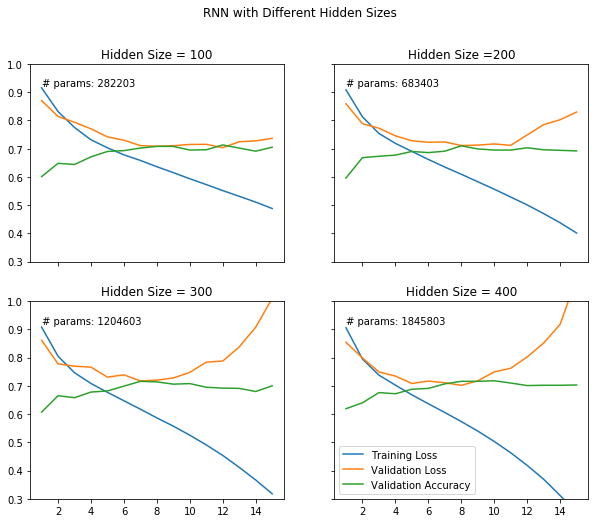

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline
plot_result(train_loss_records_hidsize, val_loss_records_hidsize, val_acc_records_hidsize,num_params_records_hidsize,\
            ["Hidden Size = 100", "Hidden Size =200", "Hidden Size = 300","Hidden Size = 400"],[100,200,300,400],\
            'RNN with Different Hidden Sizes',15)

In [35]:
for key,item in val_acc_records_hidsize.items():
    print(key,max(item))

100 71.3
200 71.0
300 71.6
400 71.8


Hidden size = 400 is best here.

### Different Ways of Interacting the Two Encoded Sentences

Concatenation & Element-wise Multiplication

In [38]:
#parameters
hidden_size = 400
interm_size = 100
learning_rate = 5e-4
num_epochs = 12 # number epoch to train

In [39]:
val_acc_records_interact = {}
train_acc_records_interact = {}
val_loss_records_interact = {}
train_loss_records_interact = {}
num_params_records_interact = {}
for interact in['concat','mul']:
    val_acc_records_interact[interact],train_acc_records_interact[interact],val_loss_records_interact[interact],train_loss_records_interact[interact],num_params_records_interact[interact] \
        = RNN_Tuning(train_sentence,train_label, val_sentence, val_label,words, loaded_embeddings, hidden_size, interm_size, interact=interact)

Epoch: [1/12], Step: [701/1563], Validation Acc: 58.8, Traning Acc: 58.954
Epoch: [1/12], Step: [1401/1563], Validation Acc: 60.5, Traning Acc: 61.405
Epoch 1 Finished! Val Loss: 0.8547204322814942, Train Loss: 0.9060353712654113
Epoch: [2/12], Step: [701/1563], Validation Acc: 63.0, Traning Acc: 64.198
Epoch: [2/12], Step: [1401/1563], Validation Acc: 63.5, Traning Acc: 66.279
Epoch 2 Finished! Val Loss: 0.7837105121612549, Train Loss: 0.8030021955871582
Epoch: [3/12], Step: [701/1563], Validation Acc: 66.7, Traning Acc: 68.191
Epoch: [3/12], Step: [1401/1563], Validation Acc: 66.3, Traning Acc: 69.448
Epoch 3 Finished! Val Loss: 0.765161768913269, Train Loss: 0.7434649846839905
Epoch: [4/12], Step: [701/1563], Validation Acc: 66.9, Traning Acc: 70.4
Epoch: [4/12], Step: [1401/1563], Validation Acc: 66.3, Traning Acc: 70.777
Epoch 4 Finished! Val Loss: 0.7422121319770812, Train Loss: 0.7056517475700378
Epoch: [5/12], Step: [701/1563], Validation Acc: 67.4, Traning Acc: 72.092
Epoch: [

In [24]:
def plot_result(train_loss, val_loss, val_acc, num_params, title_list,key_list, main, epoches_num):
    """
    Plot the results. All input data with dim [# of subplots, # of epoches]
    """
    subplot_num = len(title_list)
    fig, axes = plt.subplots((subplot_num + 1)//2 , 2, sharex= "col", sharey='row', figsize = (10,subplot_num * 2))
    epoches = np.arange(epoches_num) + 1
    val_acc_2 = {}
    for i in range(subplot_num):
        val_acc_2[key_list[i]] = [j/100 for j in val_acc[key_list[i]]]
        axes[i%2].plot(epoches,train_loss[key_list[i]], label = "Training Loss")
        axes[i%2].plot(epoches, val_loss[key_list[i]], label = "Validation Loss")
        axes[i%2].plot(epoches, val_acc_2[key_list[i]], label = "Validation Accuracy")
        axes[i%2].set_ylim([0.3,1.0])
        axes[i%2].text(1.0,0.92,"# params: " + str(num_params[key_list[i]]))
        
        axes[i%2].set_title(title_list[i])
    plt.legend()
    plt.suptitle(main)
    plt.show()

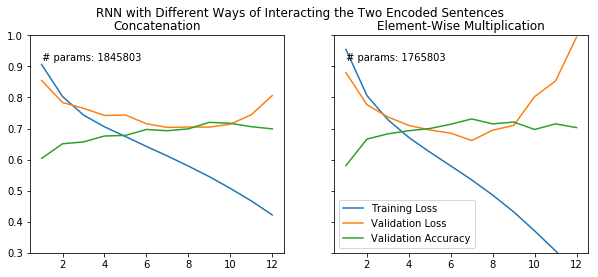

In [56]:
plot_result(train_loss_records_interact, val_loss_records_interact, val_acc_records_interact,num_params_records_interact,\
            ["Concatenation", "Element-Wise Multiplication"],['concat','mul'],\
            'RNN with Different Ways of Interacting the Two Encoded Sentences',12)

In [57]:
for key,item in val_acc_records_interact.items():
    print(key,max(item))

concat 72.0
mul 73.1


Element-wise multiplication is better here.

### Regularization

Weight decay and dropout: We set weight decay to 1e-9 and dropout to 0.5 here.

In [10]:
hidden_size = 400
interm_size = 100
learning_rate = 5e-4
num_epochs = 12
interact = 'mul'

val_acc_records_reg = {}
train_acc_records_reg = {}
val_loss_records_reg = {}
train_loss_records_reg = {}
num_params_records_reg = {}

val_acc_records_reg['no_reg'],train_acc_records_reg['no_reg'],val_loss_records_reg['no_reg'],train_loss_records_reg['no_reg'],num_params_records_reg['no_reg'] \
        = RNN_Tuning(train_sentence,train_label, val_sentence, val_label,words, loaded_embeddings, hidden_size, interm_size, interact=interact)

Epoch: [1/12], Step: [701/1563], Validation Acc: 51.5, Traning Acc: 53.144
Epoch: [1/12], Step: [1401/1563], Validation Acc: 59.7, Traning Acc: 59.86
Epoch 1 Finished! Val Loss: 0.867153733253479, Train Loss: 0.9607133271217346
Epoch: [2/12], Step: [701/1563], Validation Acc: 61.8, Traning Acc: 64.031
Epoch: [2/12], Step: [1401/1563], Validation Acc: 66.9, Traning Acc: 66.61
Epoch 2 Finished! Val Loss: 0.8052739758491516, Train Loss: 0.8140794719696045
Epoch: [3/12], Step: [701/1563], Validation Acc: 66.4, Traning Acc: 68.661
Epoch: [3/12], Step: [1401/1563], Validation Acc: 70.9, Traning Acc: 70.808
Epoch 3 Finished! Val Loss: 0.7198764033317566, Train Loss: 0.7310280164337158
Epoch: [4/12], Step: [701/1563], Validation Acc: 69.6, Traning Acc: 72.656
Epoch: [4/12], Step: [1401/1563], Validation Acc: 69.8, Traning Acc: 73.22
Epoch 4 Finished! Val Loss: 0.7057576146125794, Train Loss: 0.6725053050804138
Epoch: [5/12], Step: [701/1563], Validation Acc: 71.1, Traning Acc: 74.599
Epoch: [5

KeyboardInterrupt: 

In [14]:
num_epochs = 15
val_acc_records_reg['weight_decay'],train_acc_records_reg['weight_decay'],val_loss_records_reg['weight_decay'],train_loss_records_reg['weight_decay'],num_params_records_reg['weight_decay'] \
        = RNN_Tuning(train_sentence,train_label, val_sentence, val_label,words, loaded_embeddings, hidden_size, interm_size, interact=interact, weight_decay=1e-9)


Epoch: [1/15], Step: [701/1563], Validation Acc: 51.4, Traning Acc: 52.704
Epoch: [1/15], Step: [1401/1563], Validation Acc: 59.8, Traning Acc: 59.429
Epoch 1 Finished! Val Loss: 0.8763693423271179, Train Loss: 0.964668844985962
Epoch: [2/15], Step: [701/1563], Validation Acc: 61.1, Traning Acc: 63.03
Epoch: [2/15], Step: [1401/1563], Validation Acc: 63.8, Traning Acc: 65.46
Epoch 2 Finished! Val Loss: 0.7969843006134033, Train Loss: 0.8281944786643982
Epoch: [3/15], Step: [701/1563], Validation Acc: 65.9, Traning Acc: 67.079
Epoch: [3/15], Step: [1401/1563], Validation Acc: 66.0, Traning Acc: 68.73
Epoch 3 Finished! Val Loss: 0.7556222529411316, Train Loss: 0.7513722033500672
Epoch: [4/15], Step: [701/1563], Validation Acc: 68.7, Traning Acc: 70.694
Epoch: [4/15], Step: [1401/1563], Validation Acc: 70.3, Traning Acc: 71.793
Epoch 4 Finished! Val Loss: 0.7180102195739746, Train Loss: 0.6971035098075866
Epoch: [5/15], Step: [701/1563], Validation Acc: 68.4, Traning Acc: 73.179
Epoch: [5

In [23]:
val_acc_records_reg['dropout'],train_acc_records_reg['dropout'],val_loss_records_reg['dropout'],train_loss_records_reg['dropout'],num_params_records_reg['dropout'] \
        = RNN_Tuning(train_sentence,train_label, val_sentence, val_label,words, loaded_embeddings, hidden_size, interm_size, interact=interact, dropout=0.5)


Epoch: [1/15], Step: [701/1563], Validation Acc: 51.3, Traning Acc: 53.447
Epoch: [1/15], Step: [1401/1563], Validation Acc: 58.5, Traning Acc: 57.996
Epoch 1 Finished! Val Loss: 0.8899407963752747, Train Loss: 0.9706756749153137
Epoch: [2/15], Step: [701/1563], Validation Acc: 62.0, Traning Acc: 61.598
Epoch: [2/15], Step: [1401/1563], Validation Acc: 63.7, Traning Acc: 66.145
Epoch 2 Finished! Val Loss: 0.8106913075447083, Train Loss: 0.8406789510154724
Epoch: [3/15], Step: [701/1563], Validation Acc: 66.7, Traning Acc: 68.08
Epoch: [3/15], Step: [1401/1563], Validation Acc: 67.5, Traning Acc: 69.854
Epoch 3 Finished! Val Loss: 0.745619487285614, Train Loss: 0.7588659377288819
Epoch: [4/15], Step: [701/1563], Validation Acc: 66.5, Traning Acc: 71.098
Epoch: [4/15], Step: [1401/1563], Validation Acc: 69.4, Traning Acc: 72.693
Epoch 4 Finished! Val Loss: 0.723063497543335, Train Loss: 0.7012343106079102
Epoch: [5/15], Step: [701/1563], Validation Acc: 69.2, Traning Acc: 73.575
Epoch: [

No handles with labels found to put in legend.


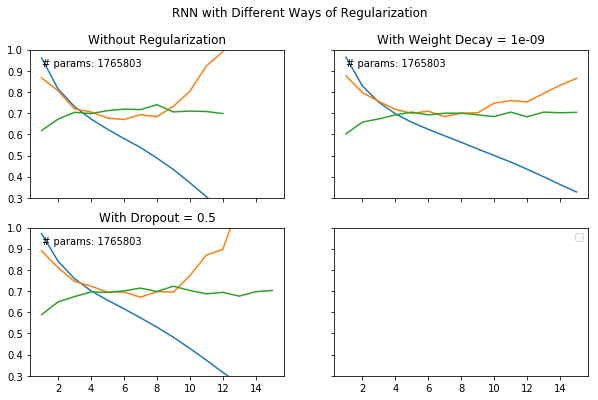

In [29]:
def plot_result(train_loss, val_loss, val_acc, num_params, title_list,key_list, main, epoches_num_list):
    """
    Plot the results. All input data with dim [# of subplots, # of epoches]
    """
    subplot_num = len(title_list)
    fig, axes = plt.subplots((subplot_num + 1)//2 , 2, sharex= "col", sharey='row', figsize = (10,subplot_num * 2))
    #epoches = np.arange(epoches_num) + 1
    val_acc_2 = {}
    for i in range(subplot_num):
        epoches = np.arange(epoches_num_list[i]) + 1
        val_acc_2[key_list[i]] = [j/100 for j in val_acc[key_list[i]]]
        axes[i//2,i%2].plot(epoches,train_loss[key_list[i]], label = "Training Loss")
        axes[i//2,i%2].plot(epoches, val_loss[key_list[i]], label = "Validation Loss")
        axes[i//2,i%2].plot(epoches, val_acc_2[key_list[i]], label = "Validation Accuracy")
        axes[i//2,i%2].set_ylim([0.3,1.0])
        axes[i//2,i%2].text(1.0,0.92,"# params: " + str(num_params[key_list[i]]))    
        axes[i//2,i%2].set_title(title_list[i])
    plt.legend()
    plt.suptitle(main)
    plt.show()
plot_result(train_loss_records_reg, val_loss_records_reg, val_acc_records_reg,num_params_records_reg,\
            ["Without Regularization", "With Weight Decay = 1e-09", "With Dropout = 0.5"],['no_reg','weight_decay', "dropout"],\
            'RNN with Different Ways of Regularization',[12, 15, 15])

In [30]:
for key,item in val_acc_records_reg.items():
    print(key,max(item))

no_reg 74.0
weight_decay 70.5
dropout 72.3


No_reg is best here.

# CNN

In [48]:
#parameters
kernel_size = 3
learning_rate = 5e-4
hidden_size = 200
interm_size = 50

In [44]:
class CNN(nn.Module):
    def __init__(self, word_embedding, hidden_size, interm_size,num_classes, kernel_size, interact, dropout):

        super(CNN, self).__init__()
        emb_size = word_embedding.shape[1]
        self.hidden_size, self.dropout = hidden_size, dropout
        self.embedding = nn.Embedding.from_pretrained(word_embedding, freeze = False)
    
        self.conv1 = nn.Conv1d(emb_size, hidden_size, kernel_size=kernel_size, padding=(kernel_size-1)//2)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_size, padding=(kernel_size-1)//2)
        if interact == 'concat':
            self.fn1 = nn.Linear(hidden_size * 2, interm_size)
        elif interact == 'mul':
            self.fn1 = nn.Linear(hidden_size, interm_size)
        if dropout != 0:
            self.dropout_layer = nn.Dropout(p = dropout)
        self.fn2 = nn.Linear(interm_size, num_classes)
        self.interact_option = interact
        
    def forward(self, x1,x2, x1_lengths, x2_lengths, x1_unsort_idx, x2_unsort_idx):
        assert(x1.size() == x2.size())
        batch_size, seq_len = x1.size()
        embed1 = self.embedding(x1.long())
        #detach the frozen word embeddings except the <unk> and <pad>
        #build mask
#         mask1 = torch.ones(embed1.shape).to(device)
#         for index1 in range(len(x1)):
#             for index2 in range(len(x1[index1])):
#                 if x1[index1][index2]==PAD_IDX or x1[index1][index2]==UNK_IDX:
#                     mask1[index1][index2].zero_()
        mask1 = (x1 == 1).type(torch.cuda.FloatTensor)
        mask1 = mask1.unsqueeze(2).repeat(1, 1, 300)
        embed1 = mask1 * embed1.float() + (1-mask1) * (embed1.clone().detach().float())
        
        embed2 = self.embedding(x2.long())
#         mask2 = torch.ones(embed2.shape).to(device)
#         for index1 in range(len(x2)):
#             for index2 in range(len(x2[index1])):
#                 if x2[index1][index2]==PAD_IDX or x2[index1][index2]==UNK_IDX:
#                     mask2[index1][index2].zero_()
        mask2 = (x2 == 1).type(torch.cuda.FloatTensor)
        mask2 = mask2.unsqueeze(2).repeat(1, 1, 300)
        embed2 = mask2 * embed2.float() + (1-mask2) * (embed2.clone().detach().float())
        
        hidden1 = self.conv1(embed1.transpose(1,2)).transpose(1,2)
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size, seq_len, hidden1.size(-1))

        hidden2 = self.conv1(embed2.transpose(1,2)).transpose(1,2)
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size, seq_len, hidden2.size(-1))

        hidden1 = self.conv2(hidden1.transpose(1,2)).transpose(1,2)
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size, seq_len, hidden1.size(-1))

        hidden2 = self.conv2(hidden2.transpose(1,2)).transpose(1,2)
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size, seq_len, hidden2.size(-1))

        maxpool =nn.MaxPool1d(kernel_size=seq_len)
        hidden1 = maxpool(hidden1.transpose(1,2)).transpose(1,2)
        hidden2 = maxpool(hidden2.transpose(1,2)).transpose(1,2)

        hidden1 = hidden1.squeeze(dim = 1)
        hidden2 = hidden2.squeeze(dim = 1)
        
        hidden1 = hidden1[x1_unsort_idx]
        hidden2 = hidden2[x2_unsort_idx]
        
        #hidden = self.conv2(hidden.transpose(1,2)).transpose(1,2)
        #hidden = F.relu(hidden.contiguous().view(-1, hidden.size(-1))).view(batch_size, seq_len, hidden.size(-1))
        if self.interact_option == 'concat':
            #concat
            hidden = torch.cat((hidden1,hidden2), 1)
        elif self.interact_option == 'mul':
            hidden = hidden1 * hidden2

        #hidden = torch.sum(hidden, dim=1)
        interm = self.fn1(hidden)
        interm = F.relu(interm)
        if self.dropout != 0:
            interm = self.dropout_layer(interm)
        logits = self.fn2(interm)
        logits = F.log_softmax(logits,dim=1)
        return logits

In [6]:
def test_model(loader, model, criterion):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    loss = 0
    model.eval()
    for x1,x2,x1_len,x2_len, x1_unsort_idx, x2_unsort_idx, labels in loader:
        x1_batch,x2_batch, x1_lengths_batch, x2_lengths_batch, x1_unsort_idx_batch, x2_unsort_idx_batch, label_batch =x1,x2,x1_len,x2_len,  x1_unsort_idx, x2_unsort_idx, labels
        x1_batch = x1_batch.long().to(device)
        x2_batch = x2_batch.long().to(device)
        x1_lengths_batch = x1_lengths_batch.to(device)
        x2_lengths_batch = x2_lengths_batch.to(device)
        label_batch = label_batch.to(device)
        outputs = model(x1_batch,x2_batch, x1_lengths_batch, x2_lengths_batch, x1_unsort_idx_batch, x2_unsort_idx_batch)
        predicted = outputs.max(1, keepdim=True)[1]
        loss += criterion(outputs, label_batch).item() *  labels.size(0)
        total += labels.size(0)
        correct += predicted.eq(label_batch.view_as(predicted)).sum().item()
    return loss/total, (100 * correct / total)


In [55]:
model = CNN(word_embedding=loaded_embeddings, hidden_size=hidden_size, num_classes=3)
model = model.to(device)
train_loss_records = []
train_acc_records = []
val_loss_records = []
val_acc_records = []
# Criterion and Optimizer
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)

for epoch in range(num_epochs):
    loss_sum = 0.0
    total = 0
    for i,(x1,x2,x1_len,x2_len, x1_unsort_idx, x2_unsort_idx, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        x1 = x1.to(device)
        x2 = x2.to(device)
        x1_len = x1_len.to(device)
        x2_len = x2_len.to(device)
        labels = labels.to(device)
        outputs = model(x1,x2,x1_len,x2_len, x1_unsort_idx, x2_unsort_idx)
        loss = criterion(outputs, labels)
        loss_sum += loss.item() * labels.size(0)
        total += labels.size(0)
        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 300 == 0:
            # validate
            val_loss, val_acc = test_model(val_loader, model)
            train_loss, train_acc = test_model(train_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}, Train Acc: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc, train_acc))
    val_loss, val_acc = test_model(val_loader, model)
    train_loss, train_acc = test_model(train_loader, model)
    print('Epoch {} Finished! Val Loss: {}, Train Loss: {}'.format(epoch+1, val_loss, train_loss))
    train_loss_records.append(loss_sum/total)
    train_acc_records.append(train_acc)
    val_loss_records.append(val_loss)
    val_acc_records.append(val_acc)

Epoch: [1/15], Step: [301/1563], Validation Acc: 58.3, Train Acc: 58.06
Epoch: [1/15], Step: [601/1563], Validation Acc: 61.7, Train Acc: 61.598
Epoch: [1/15], Step: [901/1563], Validation Acc: 63.0, Train Acc: 63.329
Epoch: [1/15], Step: [1201/1563], Validation Acc: 64.0, Train Acc: 64.571
Epoch: [1/15], Step: [1501/1563], Validation Acc: 64.3, Train Acc: 65.75
Epoch 1 Finished! Val Loss: 0.8062016968727111, Train Loss: 0.7760862085342407
Epoch: [2/15], Step: [301/1563], Validation Acc: 65.8, Train Acc: 66.882
Epoch: [2/15], Step: [601/1563], Validation Acc: 64.9, Train Acc: 67.842
Epoch: [2/15], Step: [901/1563], Validation Acc: 64.7, Train Acc: 68.745
Epoch: [2/15], Step: [1201/1563], Validation Acc: 65.8, Train Acc: 69.416
Epoch: [2/15], Step: [1501/1563], Validation Acc: 65.0, Train Acc: 69.768
Epoch 2 Finished! Val Loss: 0.7808588843345642, Train Loss: 0.7170582102966309
Epoch: [3/15], Step: [301/1563], Validation Acc: 66.9, Train Acc: 70.481
Epoch: [3/15], Step: [601/1563], Vali

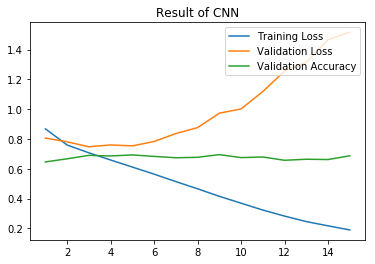

In [57]:
#visualization
#val_acc_records = [i/100 for i in val_acc_records]
epoches = np.arange(num_epochs) + 1
plt.plot(epoches,train_loss_records[15:], label = "Training Loss")
plt.plot(epoches, val_loss_records[15:], label = "Validation Loss")
plt.plot(epoches, val_acc_records[15:], label = "Validation Accuracy")
plt.legend(loc='upper right')
plt.title('Result of CNN')
plt.show()

## Parameter Tuning (CNN)

### Size of Hidden Dimension

In [7]:
words_to_load = 50000
emb_size = 300
def CNN_Tuning(train_sentence,train_label, val_sentence, val_label,words, loaded_embeddings, hidden_size, interm_size,kernel_size, interact = 'concat', weight_decay = 0,dropout = 0):
    train_dataset = SNLIDataset(train_sentence, train_label, words)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=BATCH_SIZE,
                                               collate_fn=collate_func,
                                               shuffle=True)

    val_dataset = SNLIDataset(val_sentence, val_label, words)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                               batch_size=BATCH_SIZE,
                                               collate_fn=collate_func,
                                               shuffle=False)
    model = CNN(loaded_embeddings, hidden_size=hidden_size, interm_size=interm_size, num_classes=3, kernel_size = kernel_size,interact = interact, dropout = dropout)
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    #Count number of parameters, minus the num of frozen embedding vectors since we detach them manually
    num_params = sum([np.prod(p.size()) for p in model_parameters]) - emb_size * words_to_load
    model = model.to(device)
    val_acc_records = []
    train_acc_records = []
    val_loss_records = []
    train_loss_records = []

    torch.backends.cudnn.benchmark=True
    # Criterion and Optimizer
    criterion = torch.nn.NLLLoss()
    #parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = weight_decay)

    # Train the model
    total_step = len(train_loader)

    for epoch in range(num_epochs):
        loss_sum = 0.0
        total = 0
        for i, (x1,x2,x1_len,x2_len, x1_unsort_idx, x2_unsort_idx, labels) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            # Forward pass
            x1 = x1.long().to(device)
            x2 = x2.long().to(device)
            x1_len = x1_len.to(device)
            x2_len = x2_len.to(device)
            labels = labels.to(device)
            outputs = model(x1, x2, x1_len, x2_len, x1_unsort_idx, x2_unsort_idx)

            loss = criterion(outputs, labels)

            loss_sum += loss.item() * labels.size(0)
            total += labels.size(0)
            # Backward and optimize
            loss.backward()        
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 700 == 0:
                # validate
                val_loss, val_acc = test_model(val_loader, model, criterion)
                train_loss, train_acc = test_model(train_loader, model, criterion)
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}, Traning Acc: {}'.format(
                           epoch+1, num_epochs, i+1, len(train_loader), val_acc, train_acc))
        val_loss, val_acc = test_model(val_loader, model, criterion)
        print('Epoch {} Finished! Val Loss: {}, Train Loss: {}'.format(epoch+1, val_loss, loss_sum/total))
        train_loss_records.append(loss_sum/total)
        train_acc_records.append(train_acc)
        val_loss_records.append(val_loss)
        val_acc_records.append(val_acc)
    return val_acc_records,train_acc_records,val_loss_records,train_loss_records,num_params

In [17]:
def plot_result(train_loss, val_loss, val_acc, num_params, title_list,key_list, main, epoches_num):
    """
    Plot the results. All input data with dim [# of subplots, # of epoches]
    """
    subplot_num = len(title_list)
    fig, axes = plt.subplots((subplot_num + 1)//2 , 2, sharex= "col", sharey='row', figsize = (10,subplot_num * 2))
    epoches = np.arange(epoches_num) + 1
    val_acc_2 = {}
    for i in range(subplot_num):
        val_acc_2[key_list[i]] = [j/100 for j in val_acc[key_list[i]]]
        axes[i//2,i%2].plot(epoches,train_loss[key_list[i]], label = "Training Loss")
        axes[i//2,i%2].plot(epoches, val_loss[key_list[i]], label = "Validation Loss")
        axes[i//2,i%2].plot(epoches, val_acc_2[key_list[i]], label = "Validation Accuracy")
        axes[i//2,i%2].set_ylim([0.3,1.0])
        axes[i//2,i%2].text(1.0,0.92,"# params: " + str(num_params[key_list[i]]))
        
        axes[i//2,i%2].set_title(title_list[i])
    plt.legend()
    plt.suptitle(main)
    plt.show()

In [20]:
#parameters
kernel_size = 3
learning_rate = 5e-4
interm_size = 100
num_epochs = 10

val_acc_records_hidsize_cnn_2 = {}
train_acc_records_hidsize_cnn_2 = {}
val_loss_records_hidsize_cnn_2 = {}
train_loss_records_hidsize_cnn_2 = {}
num_params_records_hidsize_cnn_2 = {}
for hidden_size in [100,200,300,400]:
    val_acc_records_hidsize_cnn_2[hidden_size],train_acc_records_hidsize_cnn_2[hidden_size],val_loss_records_hidsize_cnn_2[hidden_size],\
    train_loss_records_hidsize_cnn_2[hidden_size],num_params_records_hidsize_cnn_2[hidden_size], \
        = CNN_Tuning(train_sentence,train_label, val_sentence, val_label,words, loaded_embeddings, hidden_size, interm_size,kernel_size)

Epoch: [1/10], Step: [701/1563], Validation Acc: 61.7, Traning Acc: 61.742
Epoch: [1/10], Step: [1401/1563], Validation Acc: 62.2, Traning Acc: 64.24
Epoch 1 Finished! Val Loss: 0.8201207618713379, Train Loss: 0.8810178804016113
Epoch: [2/10], Step: [701/1563], Validation Acc: 63.6, Traning Acc: 66.026
Epoch: [2/10], Step: [1401/1563], Validation Acc: 65.1, Traning Acc: 68.331
Epoch 2 Finished! Val Loss: 0.788278226852417, Train Loss: 0.7829738822937011
Epoch: [3/10], Step: [701/1563], Validation Acc: 65.5, Traning Acc: 70.065
Epoch: [3/10], Step: [1401/1563], Validation Acc: 65.0, Traning Acc: 70.578
Epoch 3 Finished! Val Loss: 0.7726291875839233, Train Loss: 0.7300595544624329
Epoch: [4/10], Step: [701/1563], Validation Acc: 65.7, Traning Acc: 72.224
Epoch: [4/10], Step: [1401/1563], Validation Acc: 67.9, Traning Acc: 73.522
Epoch 4 Finished! Val Loss: 0.7629825887680054, Train Loss: 0.6891269156646729
Epoch: [5/10], Step: [701/1563], Validation Acc: 67.3, Traning Acc: 74.776
Epoch: 

Epoch 6 Finished! Val Loss: 0.83197625374794, Train Loss: 0.4867725076580048
Epoch: [7/10], Step: [701/1563], Validation Acc: 67.3, Traning Acc: 87.267
Epoch: [7/10], Step: [1401/1563], Validation Acc: 69.2, Traning Acc: 88.847
Epoch 7 Finished! Val Loss: 0.8871332902908325, Train Loss: 0.4136151057910919
Epoch: [8/10], Step: [701/1563], Validation Acc: 68.2, Traning Acc: 89.511
Epoch: [8/10], Step: [1401/1563], Validation Acc: 69.1, Traning Acc: 90.605
Epoch 8 Finished! Val Loss: 0.9759979047775269, Train Loss: 0.34352691511154176
Epoch: [9/10], Step: [701/1563], Validation Acc: 67.3, Traning Acc: 92.527
Epoch: [9/10], Step: [1401/1563], Validation Acc: 68.8, Traning Acc: 92.666
Epoch 9 Finished! Val Loss: 1.0759960374832154, Train Loss: 0.2783907768154144
Epoch: [10/10], Step: [701/1563], Validation Acc: 66.8, Traning Acc: 93.634
Epoch: [10/10], Step: [1401/1563], Validation Acc: 67.4, Traning Acc: 94.759
Epoch 10 Finished! Val Loss: 1.2275846710205078, Train Loss: 0.2263443416213989

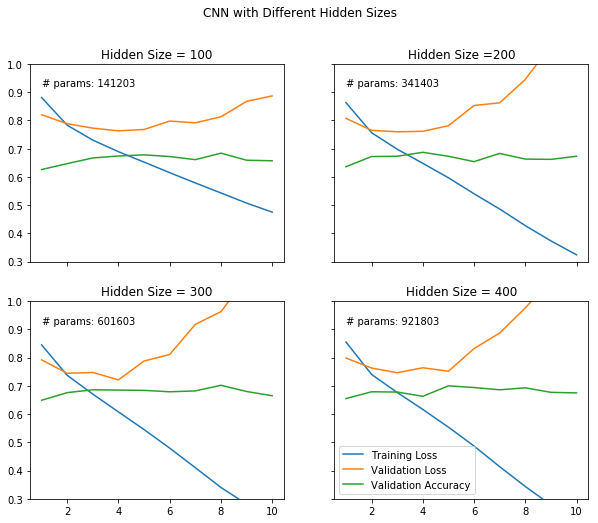

In [22]:
plot_result(train_loss_records_hidsize_cnn_2, val_loss_records_hidsize_cnn_2, val_acc_records_hidsize_cnn_2,num_params_records_hidsize_cnn_2,\
            ["Hidden Size = 100", "Hidden Size =200", "Hidden Size = 300","Hidden Size = 400"],[100,200,300,400],\
            'CNN with Different Hidden Sizes',10)

In [21]:
for key,item in val_acc_records_hidsize_cnn_2.items():
    print(key,max(item))

100 68.4
200 68.7
300 70.2
400 70.0


Hidden size = 300 is best here.

### Different Ways of Interacting the Two Encoded Sentences

In [33]:
#parameters
hidden_size = 300
interm_size = 100
kernel_size = 3
learning_rate = 5e-4
num_epochs = 10 # number epoch to train

In [34]:
val_acc_records_interact_cnn = {}
train_acc_records_interact_cnn = {}
val_loss_records_interact_cnn = {}
train_loss_records_interact_cnn = {}
num_params_records_interact_cnn = {}
for interact in['concat','mul']:
    val_acc_records_interact_cnn[interact],train_acc_records_interact_cnn[interact],val_loss_records_interact_cnn[interact],train_loss_records_interact_cnn[interact],num_params_records_interact_cnn[interact] \
        = CNN_Tuning(train_sentence,train_label, val_sentence, val_label,words, loaded_embeddings, hidden_size, interm_size,kernel_size, interact=interact)

Epoch: [1/10], Step: [701/1563], Validation Acc: 61.7, Traning Acc: 62.803
Epoch: [1/10], Step: [1401/1563], Validation Acc: 63.8, Traning Acc: 66.237
Epoch 1 Finished! Val Loss: 0.7917230710983276, Train Loss: 0.8522055942726136
Epoch: [2/10], Step: [701/1563], Validation Acc: 65.0, Traning Acc: 69.009
Epoch: [2/10], Step: [1401/1563], Validation Acc: 66.0, Traning Acc: 71.087
Epoch 2 Finished! Val Loss: 0.7566755247116089, Train Loss: 0.7432971176528931
Epoch: [3/10], Step: [701/1563], Validation Acc: 64.9, Traning Acc: 72.832
Epoch: [3/10], Step: [1401/1563], Validation Acc: 69.1, Traning Acc: 75.459
Epoch 3 Finished! Val Loss: 0.75173725938797, Train Loss: 0.6797366572761535
Epoch: [4/10], Step: [701/1563], Validation Acc: 66.9, Traning Acc: 76.948
Epoch: [4/10], Step: [1401/1563], Validation Acc: 69.2, Traning Acc: 78.462
Epoch 4 Finished! Val Loss: 0.7404318571090698, Train Loss: 0.616493646030426
Epoch: [5/10], Step: [701/1563], Validation Acc: 68.9, Traning Acc: 80.867
Epoch: [

In [35]:
def plot_result(train_loss, val_loss, val_acc, num_params, title_list,key_list, main, epoches_num):
    """
    Plot the results. All input data with dim [# of subplots, # of epoches]
    """
    subplot_num = len(title_list)
    fig, axes = plt.subplots((subplot_num + 1)//2 , 2, sharex= "col", sharey='row', figsize = (10,subplot_num * 2))
    epoches = np.arange(epoches_num) + 1
    val_acc_2 = {}
    for i in range(subplot_num):
        val_acc_2[key_list[i]] = [j/100 for j in val_acc[key_list[i]]]
        axes[i%2].plot(epoches,train_loss[key_list[i]], label = "Training Loss")
        axes[i%2].plot(epoches, val_loss[key_list[i]], label = "Validation Loss")
        axes[i%2].plot(epoches, val_acc_2[key_list[i]], label = "Validation Accuracy")
        axes[i%2].set_ylim([0.3,1.0])
        axes[i%2].text(1.0,0.92,"# params: " + str(num_params[key_list[i]]))
        
        axes[i%2].set_title(title_list[i])
    plt.legend()
    plt.suptitle(main)
    plt.show()

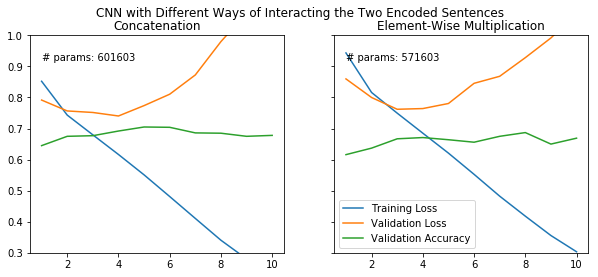

In [36]:
plot_result(train_loss_records_interact_cnn, val_loss_records_interact_cnn, val_acc_records_interact_cnn,num_params_records_interact_cnn,\
            ["Concatenation", "Element-Wise Multiplication"],['concat','mul'],\
            'CNN with Different Ways of Interacting the Two Encoded Sentences',10)

In [37]:
for key,item in val_acc_records_interact_cnn.items():
    print(key,max(item))

concat 70.5
mul 68.7


Concatenation is better here.

### Kernel Size

In [38]:
#parameters
hidden_size = 300
interm_size = 100
learning_rate = 5e-4
num_epochs = 10 # number epoch to train

In [49]:
val_acc_records_kernel = {}
train_acc_records_kernel = {}
val_loss_records_kernel = {}
train_loss_records_kernel = {}
num_params_records_kernel = {}
for kernel_size in[1,3,5,7]:
    val_acc_records_kernel[kernel_size],train_acc_records_kernel[kernel_size],val_loss_records_kernel[kernel_size],train_loss_records_kernel[kernel_size],num_params_records_kernel[kernel_size] \
        = CNN_Tuning(train_sentence,train_label, val_sentence, val_label,words, loaded_embeddings, hidden_size, interm_size,kernel_size)

Epoch: [1/10], Step: [701/1563], Validation Acc: 60.3, Traning Acc: 62.57
Epoch: [1/10], Step: [1401/1563], Validation Acc: 64.6, Traning Acc: 65.632
Epoch 1 Finished! Val Loss: 0.7996895146369934, Train Loss: 0.8606171748161316
Epoch: [2/10], Step: [701/1563], Validation Acc: 67.1, Traning Acc: 67.566
Epoch: [2/10], Step: [1401/1563], Validation Acc: 66.8, Traning Acc: 68.373
Epoch 2 Finished! Val Loss: 0.7659225120544434, Train Loss: 0.7661137701034546
Epoch: [3/10], Step: [701/1563], Validation Acc: 67.2, Traning Acc: 69.045
Epoch: [3/10], Step: [1401/1563], Validation Acc: 69.1, Traning Acc: 70.233
Epoch 3 Finished! Val Loss: 0.7371503639221192, Train Loss: 0.7288671725654602
Epoch: [4/10], Step: [701/1563], Validation Acc: 70.1, Traning Acc: 71.545
Epoch: [4/10], Step: [1401/1563], Validation Acc: 70.4, Traning Acc: 73.03
Epoch 4 Finished! Val Loss: 0.7136887850761413, Train Loss: 0.6902398489189148
Epoch: [5/10], Step: [701/1563], Validation Acc: 70.8, Traning Acc: 73.87
Epoch: [

Epoch 6 Finished! Val Loss: 1.0293829183578491, Train Loss: 0.35699151639938353
Epoch: [7/10], Step: [701/1563], Validation Acc: 65.2, Traning Acc: 92.993
Epoch: [7/10], Step: [1401/1563], Validation Acc: 65.7, Traning Acc: 93.084
Epoch 7 Finished! Val Loss: 1.1524769916534423, Train Loss: 0.2634065943670273
Epoch: [8/10], Step: [701/1563], Validation Acc: 64.7, Traning Acc: 94.718
Epoch: [8/10], Step: [1401/1563], Validation Acc: 64.9, Traning Acc: 95.771
Epoch 8 Finished! Val Loss: 1.3329019794464112, Train Loss: 0.19476245630979538
Epoch: [9/10], Step: [701/1563], Validation Acc: 65.0, Traning Acc: 95.148
Epoch: [9/10], Step: [1401/1563], Validation Acc: 64.3, Traning Acc: 96.76
Epoch 9 Finished! Val Loss: 1.6675626029968262, Train Loss: 0.15155346527099609
Epoch: [10/10], Step: [701/1563], Validation Acc: 64.7, Traning Acc: 96.851
Epoch: [10/10], Step: [1401/1563], Validation Acc: 62.9, Traning Acc: 96.981
Epoch 10 Finished! Val Loss: 1.8003356924057008, Train Loss: 0.1242555551695

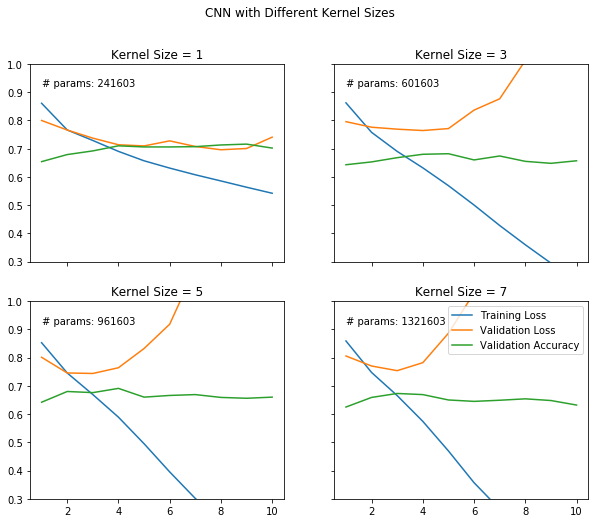

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_result(train_loss, val_loss, val_acc, num_params, title_list,key_list, main, epoches_num):
    """
    Plot the results. All input data with dim [# of subplots, # of epoches]
    """
    subplot_num = len(title_list)
    fig, axes = plt.subplots((subplot_num + 1)//2 , 2, sharex= "col", sharey='row', figsize = (10,subplot_num * 2))
    epoches = np.arange(epoches_num) + 1
    val_acc_2 = {}
    for i in range(subplot_num):
        val_acc_2[key_list[i]] = [j/100 for j in val_acc[key_list[i]]]
        axes[i//2,i%2].plot(epoches,train_loss[key_list[i]], label = "Training Loss")
        axes[i//2,i%2].plot(epoches, val_loss[key_list[i]], label = "Validation Loss")
        axes[i//2,i%2].plot(epoches, val_acc_2[key_list[i]], label = "Validation Accuracy")
        axes[i//2,i%2].set_ylim([0.3,1.0])
        axes[i//2,i%2].text(1.0,0.92,"# params: " + str(num_params[key_list[i]]))
        
        axes[i//2,i%2].set_title(title_list[i])
    plt.legend()
    plt.suptitle(main)
    plt.show()
    
plot_result(train_loss_records_kernel, val_loss_records_kernel, val_acc_records_kernel,num_params_records_kernel,\
            ["Kernel Size = 1", "Kernel Size = 3", "Kernel Size = 5", "Kernel Size = 7"],[1,3,5,7],\
            'CNN with Different Kernel Sizes',10)

In [51]:
for key,item in val_acc_records_kernel.items():
    print(key,max(item))

1 71.6
3 68.2
5 69.1
7 67.3


kernal_size = 1 is best here.

### Regularization

Set weight decay to 1e-09 and dropout to 0.5.

In [11]:
hidden_size = 300
interm_size = 100
kernel_size = 1
learning_rate = 5e-4
num_epochs = 20
interact = 'concat'

val_acc_records_reg = {}
train_acc_records_reg = {}
val_loss_records_reg = {}
train_loss_records_reg = {}
num_params_records_reg = {}

val_acc_records_reg['no_reg'],train_acc_records_reg['no_reg'],val_loss_records_reg['no_reg'],train_loss_records_reg['no_reg'],num_params_records_reg['no_reg'] \
        = CNN_Tuning(train_sentence,train_label, val_sentence, val_label,words, loaded_embeddings, hidden_size, interm_size, kernel_size, interact=interact)

Epoch: [1/20], Step: [701/1563], Validation Acc: 60.7, Traning Acc: 62.55
Epoch: [1/20], Step: [1401/1563], Validation Acc: 64.3, Traning Acc: 65.484
Epoch 1 Finished! Val Loss: 0.825653772354126, Train Loss: 0.8614392094993591
Epoch: [2/20], Step: [701/1563], Validation Acc: 66.0, Traning Acc: 67.664
Epoch: [2/20], Step: [1401/1563], Validation Acc: 66.1, Traning Acc: 68.43
Epoch 2 Finished! Val Loss: 0.7662108011245727, Train Loss: 0.7641703957939148
Epoch: [3/20], Step: [701/1563], Validation Acc: 68.6, Traning Acc: 69.856
Epoch: [3/20], Step: [1401/1563], Validation Acc: 66.8, Traning Acc: 70.863
Epoch 3 Finished! Val Loss: 0.7562248182296752, Train Loss: 0.7260768064117432
Epoch: [4/20], Step: [701/1563], Validation Acc: 68.5, Traning Acc: 71.422
Epoch: [4/20], Step: [1401/1563], Validation Acc: 69.6, Traning Acc: 71.61
Epoch 4 Finished! Val Loss: 0.7680636706352234, Train Loss: 0.6946487085151672
Epoch: [5/20], Step: [701/1563], Validation Acc: 70.8, Traning Acc: 72.948
Epoch: [5

In [12]:
val_acc_records_reg['weight_decay'],train_acc_records_reg['weight_decay'],val_loss_records_reg['weight_decay'],train_loss_records_reg['weight_decay'],num_params_records_reg['weight_decay'] \
        = CNN_Tuning(train_sentence,train_label, val_sentence, val_label,words, loaded_embeddings, hidden_size, interm_size, kernel_size, interact=interact, weight_decay = 1e-9)

Epoch: [1/20], Step: [701/1563], Validation Acc: 59.7, Traning Acc: 60.353
Epoch: [1/20], Step: [1401/1563], Validation Acc: 63.7, Traning Acc: 64.704
Epoch 1 Finished! Val Loss: 0.8207889742851258, Train Loss: 0.8678642221450805
Epoch: [2/20], Step: [701/1563], Validation Acc: 65.6, Traning Acc: 67.226
Epoch: [2/20], Step: [1401/1563], Validation Acc: 64.9, Traning Acc: 67.976
Epoch 2 Finished! Val Loss: 0.7721477670669555, Train Loss: 0.7692316547966004
Epoch: [3/20], Step: [701/1563], Validation Acc: 67.4, Traning Acc: 69.474
Epoch: [3/20], Step: [1401/1563], Validation Acc: 68.1, Traning Acc: 70.256
Epoch 3 Finished! Val Loss: 0.7441582026481628, Train Loss: 0.7305418181610107
Epoch: [4/20], Step: [701/1563], Validation Acc: 68.4, Traning Acc: 71.274
Epoch: [4/20], Step: [1401/1563], Validation Acc: 69.7, Traning Acc: 71.239
Epoch 4 Finished! Val Loss: 0.7540252237319947, Train Loss: 0.702975190525055
Epoch: [5/20], Step: [701/1563], Validation Acc: 69.1, Traning Acc: 72.793
Epoch:

In [13]:
val_acc_records_reg['dropout'],train_acc_records_reg['dropout'],val_loss_records_reg['dropout'],train_loss_records_reg['dropout'],num_params_records_reg['dropout'] \
        = CNN_Tuning(train_sentence,train_label, val_sentence, val_label, words, loaded_embeddings, hidden_size, interm_size, kernel_size, interact=interact, dropout= 0.5)

Epoch: [1/20], Step: [701/1563], Validation Acc: 59.5, Traning Acc: 61.986
Epoch: [1/20], Step: [1401/1563], Validation Acc: 63.4, Traning Acc: 64.621
Epoch 1 Finished! Val Loss: 0.806712760925293, Train Loss: 0.8820445199012756
Epoch: [2/20], Step: [701/1563], Validation Acc: 65.6, Traning Acc: 65.423
Epoch: [2/20], Step: [1401/1563], Validation Acc: 67.3, Traning Acc: 67.769
Epoch 2 Finished! Val Loss: 0.769513617515564, Train Loss: 0.7924664511871338
Epoch: [3/20], Step: [701/1563], Validation Acc: 67.9, Traning Acc: 68.799
Epoch: [3/20], Step: [1401/1563], Validation Acc: 68.9, Traning Acc: 69.534
Epoch 3 Finished! Val Loss: 0.7530552759170532, Train Loss: 0.756539323310852
Epoch: [4/20], Step: [701/1563], Validation Acc: 68.4, Traning Acc: 70.228
Epoch: [4/20], Step: [1401/1563], Validation Acc: 70.3, Traning Acc: 71.573
Epoch 4 Finished! Val Loss: 0.7325423574447631, Train Loss: 0.727575032749176
Epoch: [5/20], Step: [701/1563], Validation Acc: 69.4, Traning Acc: 72.094
Epoch: [5

No handles with labels found to put in legend.


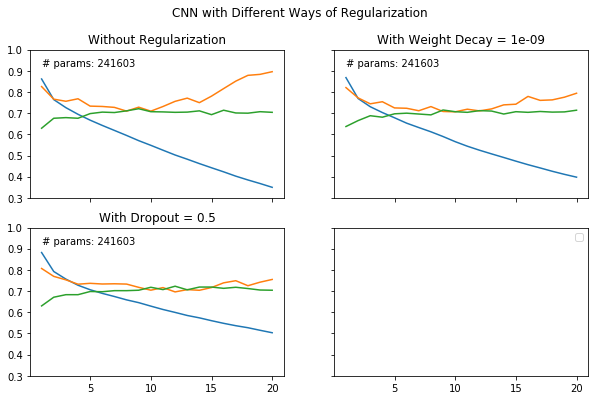

In [15]:
def plot_result(train_loss, val_loss, val_acc, num_params, title_list,key_list, main, epoches_num_list):
    """
    Plot the results. All input data with dim [# of subplots, # of epoches]
    """
    subplot_num = len(title_list)
    fig, axes = plt.subplots((subplot_num + 1)//2 , 2, sharex= "col", sharey='row', figsize = (10,subplot_num * 2))
    #epoches = np.arange(epoches_num) + 1
    val_acc_2 = {}
    for i in range(subplot_num):
        epoches = np.arange(epoches_num_list[i]) + 1
        val_acc_2[key_list[i]] = [j/100 for j in val_acc[key_list[i]]]
        axes[i//2,i%2].plot(epoches,train_loss[key_list[i]], label = "Training Loss")
        axes[i//2,i%2].plot(epoches, val_loss[key_list[i]], label = "Validation Loss")
        axes[i//2,i%2].plot(epoches, val_acc_2[key_list[i]], label = "Validation Accuracy")
        axes[i//2,i%2].set_ylim([0.3,1.0])
        axes[i//2,i%2].text(1.0,0.92,"# params: " + str(num_params[key_list[i]]))    
        axes[i//2,i%2].set_title(title_list[i])
    plt.legend()
    plt.suptitle(main)
    plt.show()
plot_result(train_loss_records_reg, val_loss_records_reg, val_acc_records_reg,num_params_records_reg,\
            ["Without Regularization", "With Weight Decay = 1e-09", "With Dropout = 0.5"],['no_reg','weight_decay', "dropout"],\
            'CNN with Different Ways of Regularization',[20, 20, 20])

In [16]:
for key,item in val_acc_records_reg.items():
    print(key,max(item))

no_reg 72.1
weight_decay 71.5
dropout 72.3


Dropout is best here.

## Take Best Model & Highlight 3 Correct and 3 Incorrect Predictions

Present beast model: RNN with parameters listed below:

In [21]:
hidden_size = 400
interm_size = 100
learning_rate = 5e-4
interact = 'mul'
num_epochs = 8

In [33]:
words_to_load = 50000
emb_size = 300
def RNN_Best(train_sentence,train_label, val_sentence, val_label,words, loaded_embeddings, hidden_size, interm_size, interact = 'concat', weight_decay = 0, dropout = 0):
    train_dataset = SNLIDataset(train_sentence, train_label, words)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=BATCH_SIZE,
                                               collate_fn=collate_func,
                                               shuffle=True)

    val_dataset = SNLIDataset(val_sentence, val_label, words)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                               batch_size=BATCH_SIZE,
                                               collate_fn=collate_func,
                                               shuffle=False)
    model = RNN(loaded_embeddings, hidden_size=hidden_size, interm_size=interm_size, num_layers=1, num_classes=3, interact = interact, dropout = dropout)
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    #Count number of parameters, minus the num of frozen embedding vectors since we detach them manually
    num_params = sum([np.prod(p.size()) for p in model_parameters]) - emb_size * words_to_load
    model = model.to(device)

    torch.backends.cudnn.benchmark=True
    # Criterion and Optimizer
    criterion = torch.nn.NLLLoss()
    #parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Train the model
    total_step = len(train_loader)

    for epoch in range(num_epochs):
        for i, (x1,x2,x1_len,x2_len, x1_unsort_idx, x2_unsort_idx, labels) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            # Forward pass
            x1 = x1.long().to(device)
            x2 = x2.long().to(device)
            x1_len = x1_len.to(device)
            x2_len = x2_len.to(device)
            labels = labels.to(device)
            outputs = model(x1, x2, x1_len, x2_len, x1_unsort_idx, x2_unsort_idx)
            loss = criterion(outputs, labels)
            # Backward and optimize
            loss.backward()        
            optimizer.step()
            if i > 0 and i % 700 == 0:
                print('Epoch: [{}/{}], Step: [{}/{}]'.format(epoch+1, num_epochs, i+1, len(train_loader)))
#     val_loss, val_acc, correct_list, incorrect_list = test_model(val_loader, model, criterion)
#     train_loss, train_acc, _,_ = test_model(train_loader, model, criterion)
#     print('Finished! Val Loss: {}, Train Loss: {}, Val Acc: {}, Train Acc: {}'.format(val_loss, train_loss, val_acc, train_acc))
    return val_loader,criterion,model

In [34]:
val_loader,criterion, model = RNN_Best(train_sentence,train_label, val_sentence, val_label,words, loaded_embeddings, hidden_size, interm_size, interact=interact)

Epoch: [1/8], Step: [701/1563]
Epoch: [1/8], Step: [1401/1563]
Epoch: [2/8], Step: [701/1563]
Epoch: [2/8], Step: [1401/1563]
Epoch: [3/8], Step: [701/1563]
Epoch: [3/8], Step: [1401/1563]
Epoch: [4/8], Step: [701/1563]
Epoch: [4/8], Step: [1401/1563]
Epoch: [5/8], Step: [701/1563]
Epoch: [5/8], Step: [1401/1563]
Epoch: [6/8], Step: [701/1563]
Epoch: [6/8], Step: [1401/1563]
Epoch: [7/8], Step: [701/1563]
Epoch: [7/8], Step: [1401/1563]
Epoch: [8/8], Step: [701/1563]
Epoch: [8/8], Step: [1401/1563]


In [25]:
def test_best_model(loader, model, criterion, correct_num, incorrect_num):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    loss = 0
    correct_list = []
    incorrect_list = []
    
    model.eval()
    for x1,x2,x1_len,x2_len, x1_unsort_idx, x2_unsort_idx, labels in loader:
        x1_batch,x2_batch, x1_lengths_batch, x2_lengths_batch, x1_unsort_idx_batch, x2_unsort_idx_batch, label_batch =x1,x2,x1_len,x2_len,  x1_unsort_idx, x2_unsort_idx, labels
        x1_batch = x1_batch.long().to(device)
        x2_batch = x2_batch.long().to(device)
        x1_lengths_batch = x1_lengths_batch.to(device)
        x2_lengths_batch = x2_lengths_batch.to(device)
        label_batch = label_batch.to(device)
        outputs = model(x1_batch,x2_batch, x1_lengths_batch, x2_lengths_batch, x1_unsort_idx_batch, x2_unsort_idx_batch)
        #unsort the sentences
        x1_batch = x1_batch[x1_unsort_idx_batch]
        x2_batch = x2_batch[x2_unsort_idx_batch]
        predicted = outputs.max(1, keepdim=True)[1]
        loss += criterion(outputs, label_batch).item() *  labels.size(0)
        total += label_batch.size(0)
        correct += predicted.eq(label_batch.view_as(predicted)).sum().item()
        for index,item in enumerate(predicted):
            if len(correct_list) >= correct_num and len(incorrect_list) >= incorrect_num:
                break
            elif len(correct_list) < correct_num and item == label_batch.view_as(predicted)[index]:
                correct_list.append([x1_batch[index], x2_batch[index], item])
            elif len(incorrect_list) < incorrect_num and item != label_batch.view_as(predicted)[index]:
                incorrect_list.append([x1_batch[index], x2_batch[index], item, label_batch.view_as(predicted)[index]])
                
    return loss/total,(100 * correct / total), correct_list, incorrect_list

In [35]:
loss, acc, correct_list, incorrect_list = test_best_model(val_loader, model, criterion, 3, 3)

In [36]:
print(loss, acc)

0.6995793867111206 72.5


In [43]:
def sentence_decode(x, idx2words):
    return [idx2words[k] for k in x]

int2label = {2:'entailment', 0:'contradiction',1: 'neutral'} 
print('Correct Predictions Example: ')
for correct_cuda in correct_list:
    correct = [x.cpu().numpy() for x in correct_cuda]
    print('Sentence 1: ', ' '.join(sentence_decode(correct[0],idx2words)))
    print('Sentence 2: ', ' '.join(sentence_decode(correct[1], idx2words)))
    print('Label: ', int2label[correct[2][0]])
print('Incorrect Predictions Example: ')    
for incorrect_cuda in incorrect_list:
    incorrect = [x.cpu().numpy() for x in incorrect_cuda]
    print('Sentence 1: ', ' '.join(sentence_decode(incorrect[0],idx2words)))
    print('Sentence 2: ', ' '.join(sentence_decode(incorrect[1],idx2words)))
    print('Predicted Label: ', int2label[incorrect[2][0]])
    print('True Label: ', int2label[incorrect[3][0]])

Correct Predictions Example: 
Sentence 1:  Three women on a stage , one wearing red shoes , black pants , and a gray shirt is sitting on a prop , another is sitting on the floor
Sentence 2:  There are two women standing on the stage <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Label:  contradiction
Sentence 1:  Four people sit on a subway two read books , one looks at a cellphone and is wearing knee high boots . <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Sentence 2:  Multiple people are on a subway together , with each of them doing their own thing . <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Label:  entailment
Sentence 1:  Man in <unk> with two horses . <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Sentence 2:  a man in <unk> with two horses <pad> <pad> <pad> <pad> <pad

# Evaluating on MultiNLI

In [22]:
import pandas as pd
#read the dataset
val_data_mnli = pd.read_csv('mnli_val.tsv', sep = '\t')

In [23]:
#trasfer the label to integer, entailment = 2, contradiction = 0, neutral = 1
val_data_mnli.loc[val_data_mnli['label'] == 'entailment','int_label'] = 2
val_data_mnli.loc[val_data_mnli['label'] == 'neutral','int_label'] = 1
val_data_mnli.loc[val_data_mnli['label'] == 'contradiction','int_label'] = 0

In [24]:
val_data_mnli.head()

,sentence1,sentence2,label,genre,int_label
0,"'Not entirely , ' I snapped , harsher than int...",I spoke more harshly than I wanted to .,entailment,fiction,2.0
1,cook and then the next time it would be my tur...,I would cook and then the next turn would be h...,contradiction,telephone,0.0
2,The disorder hardly seemed to exist before the...,The disorder did n't seem to be as common when...,entailment,slate,2.0
3,"The Report and Order , in large part , adopts ...",The Report and Order ignores recommendations f...,contradiction,government,0.0
4,"IDPA 's OIG 's mission is to prevent , detect ...",IDPA 's OIG 's mission is clear and cares abou...,entailment,government,2.0


In [50]:
val_data_mnli["genre"].value_counts()

government    1016
telephone     1005
slate         1002
fiction        995
travel         982
Name: genre, dtype: int64

In [72]:
def test_mnli_model(loader, model, criterion):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    loss = 0

    model.eval()
    for x1,x2,x1_len,x2_len, x1_unsort_idx, x2_unsort_idx, labels in loader:
        x1_batch,x2_batch, x1_lengths_batch, x2_lengths_batch, x1_unsort_idx_batch, x2_unsort_idx_batch, label_batch =x1,x2,x1_len,x2_len,x1_unsort_idx, x2_unsort_idx, labels
        x1_batch = x1_batch.long().to(device)
        x2_batch = x2_batch.long().to(device)
        x1_lengths_batch = x1_lengths_batch.to(device)
        x2_lengths_batch = x2_lengths_batch.to(device)
        label_batch = label_batch.to(device)
        outputs = model(x1_batch,x2_batch, x1_lengths_batch, x2_lengths_batch, x1_unsort_idx_batch, x2_unsort_idx_batch)
        predicted = outputs.max(1, keepdim=True)[1]
        loss += criterion(outputs, label_batch).item() *  labels.size(0)
        total += label_batch.size(0)
        correct += predicted.eq(label_batch.view_as(predicted)).sum().item()
    return (100 * correct / total)

## RNN

In [91]:
hidden_size = 400
interm_size = 100
learning_rate = 5e-4
interact = 'mul'
num_epochs = 8

In [92]:
_,criterion, model = RNN_Best(train_sentence,train_label, val_sentence, val_label,words, loaded_embeddings, hidden_size, interm_size, interact=interact)

Epoch: [1/8], Step: [701/1563]
Epoch: [1/8], Step: [1401/1563]
Epoch: [2/8], Step: [701/1563]
Epoch: [2/8], Step: [1401/1563]
Epoch: [3/8], Step: [701/1563]
Epoch: [3/8], Step: [1401/1563]
Epoch: [4/8], Step: [701/1563]
Epoch: [4/8], Step: [1401/1563]
Epoch: [5/8], Step: [701/1563]
Epoch: [5/8], Step: [1401/1563]
Epoch: [6/8], Step: [701/1563]
Epoch: [6/8], Step: [1401/1563]
Epoch: [7/8], Step: [701/1563]
Epoch: [7/8], Step: [1401/1563]
Epoch: [8/8], Step: [701/1563]
Epoch: [8/8], Step: [1401/1563]


In [93]:
torch.save(model.state_dict(), "best_rnn_model_states")

In [32]:
model = RNN(loaded_embeddings, hidden_size=hidden_size, interm_size=interm_size, num_layers=1, num_classes=3, interact = interact, dropout = 0)
model.load_state_dict(torch.load('best_rnn_model_states'))

In [36]:
for genre, val_data_mnli_genre in val_data_mnli.groupby('genre'):
    val_mnli_sentence = val_data_mnli_genre[['sentence1','sentence2']].values
    val_mnli_label = val_data_mnli_genre['int_label'].values
    val_mnli_dataset = SNLIDataset(val_mnli_sentence, val_mnli_label, words)
    val_mnli_loader = torch.utils.data.DataLoader(dataset=val_mnli_dataset,
                                               batch_size=BATCH_SIZE,
                                               collate_fn=collate_func,
                                               shuffle=False)
    val_mnli_acc_genre[genre] = test_mnli_model(val_mnli_loader, model, criterion)
    print('The acc for {} is {}'.format(genre, val_mnli_acc_genre[genre]))

The acc for fiction is (1.6409752084981257, 33.66834170854271)
The acc for government is (1.6466075914112601, 34.44881889763779)
The acc for slate is (1.5516454176512544, 33.43313373253493)
The acc for telephone is (1.7190439304902185, 34.12935323383085)
The acc for travel is (1.6507933562253498, 35.132382892057024)


# CNN

In [37]:
hidden_size = 300
interm_size = 100
kernel_size = 1
learning_rate = 5e-4
num_epochs = 12
interact = 'concat'
dropout = 0.5

In [38]:
words_to_load = 50000
emb_size = 300
def CNN_Best(train_sentence,train_label, val_sentence, val_label,words, loaded_embeddings, hidden_size, interm_size,kernel_size, interact = 'concat', weight_decay = 0,dropout = 0):
    train_dataset = SNLIDataset(train_sentence, train_label, words)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=BATCH_SIZE,
                                               collate_fn=collate_func,
                                               shuffle=True)

    val_dataset = SNLIDataset(val_sentence, val_label, words)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                               batch_size=BATCH_SIZE,
                                               collate_fn=collate_func,
                                               shuffle=False)
    model = CNN(loaded_embeddings, hidden_size=hidden_size, interm_size=interm_size, num_classes=3, kernel_size = kernel_size,interact = interact, dropout = dropout)
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    #Count number of parameters, minus the num of frozen embedding vectors since we detach them manually
    num_params = sum([np.prod(p.size()) for p in model_parameters]) - emb_size * words_to_load
    model = model.to(device)
    
    torch.backends.cudnn.benchmark=True
    # Criterion and Optimizer
    criterion = torch.nn.NLLLoss()
    #parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = weight_decay)

    # Train the model
    total_step = len(train_loader)

    for epoch in range(num_epochs):
        for i, (x1,x2,x1_len,x2_len, x1_unsort_idx, x2_unsort_idx, labels) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            # Forward pass
            x1 = x1.long().to(device)
            x2 = x2.long().to(device)
            x1_len = x1_len.to(device)
            x2_len = x2_len.to(device)
            labels = labels.to(device)
            outputs = model(x1, x2, x1_len, x2_len, x1_unsort_idx, x2_unsort_idx)

            loss = criterion(outputs, labels)
            # Backward and optimize
            loss.backward()        
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 700 == 0:
                print('Epoch: [{}/{}], Step: [{}/{}]'.format(epoch+1, num_epochs, i+1, len(train_loader)))
    return criterion,model

In [45]:
criterion_cnn, model_cnn = CNN_Best(train_sentence,train_label, val_sentence, val_label,words, loaded_embeddings,\
                                    hidden_size, interm_size, kernel_size, interact = interact, dropout = dropout)

Epoch: [1/12], Step: [701/1563]
Epoch: [1/12], Step: [1401/1563]
Epoch: [2/12], Step: [701/1563]
Epoch: [2/12], Step: [1401/1563]
Epoch: [3/12], Step: [701/1563]
Epoch: [3/12], Step: [1401/1563]
Epoch: [4/12], Step: [701/1563]
Epoch: [4/12], Step: [1401/1563]
Epoch: [5/12], Step: [701/1563]
Epoch: [5/12], Step: [1401/1563]
Epoch: [6/12], Step: [701/1563]
Epoch: [6/12], Step: [1401/1563]
Epoch: [7/12], Step: [701/1563]
Epoch: [7/12], Step: [1401/1563]
Epoch: [8/12], Step: [701/1563]
Epoch: [8/12], Step: [1401/1563]
Epoch: [9/12], Step: [701/1563]
Epoch: [9/12], Step: [1401/1563]
Epoch: [10/12], Step: [701/1563]
Epoch: [10/12], Step: [1401/1563]
Epoch: [11/12], Step: [701/1563]
Epoch: [11/12], Step: [1401/1563]
Epoch: [12/12], Step: [701/1563]
Epoch: [12/12], Step: [1401/1563]


In [46]:
val_mnli_acc_genre_cnn ={}
for genre, val_data_mnli_genre in val_data_mnli.groupby('genre'):
    val_mnli_sentence = val_data_mnli_genre[['sentence1','sentence2']].values
    val_mnli_label = val_data_mnli_genre['int_label'].values
    val_mnli_dataset = SNLIDataset(val_mnli_sentence, val_mnli_label, words)
    val_mnli_loader = torch.utils.data.DataLoader(dataset=val_mnli_dataset,
                                               batch_size=BATCH_SIZE,
                                               collate_fn=collate_func,
                                               shuffle=False)
    val_mnli_acc_genre_cnn[genre] = test_mnli_model(val_mnli_loader, model_cnn, criterion_cnn)
    print('The acc for {} is {}'.format(genre, val_mnli_acc_genre[genre]))

The acc for fiction is (1.6409752084981257, 33.66834170854271)
The acc for government is (1.6466075914112601, 34.44881889763779)
The acc for slate is (1.5516454176512544, 33.43313373253493)
The acc for telephone is (1.7190439304902185, 34.12935323383085)
The acc for travel is (1.6507933562253498, 35.132382892057024)


# Fine-tuning on MultiNLI

In [15]:
import pandas as pd
#load the muli train dataset
train_data_mnli = pd.read_csv('mnli_train.tsv', sep = '\t')

In [16]:
#trasfer the label to integer, entailment = 2, contradiction = 0, neutral = 1
train_data_mnli.loc[train_data_mnli['label'] == 'entailment','int_label'] = 2
train_data_mnli.loc[train_data_mnli['label'] == 'neutral','int_label'] = 1
train_data_mnli.loc[train_data_mnli['label'] == 'contradiction','int_label'] = 0

In [17]:
train_data_mnli['genre'].value_counts()

telephone     4270
slate         4026
travel        3985
government    3883
fiction       3836
Name: genre, dtype: int64

In [50]:
hidden_size = 400
interm_size = 100
learning_rate = 5e-4
interact = 'mul'

In [51]:
def test_mnli_model(loader, model, criterion):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    loss = 0

    model.eval()
    for x1,x2,x1_len,x2_len, x1_unsort_idx, x2_unsort_idx, labels in loader:
        x1_batch,x2_batch, x1_lengths_batch, x2_lengths_batch, x1_unsort_idx_batch, x2_unsort_idx_batch, label_batch =x1,x2,x1_len,x2_len,x1_unsort_idx, x2_unsort_idx, labels
        x1_batch = x1_batch.long().to(device)
        x2_batch = x2_batch.long().to(device)
        x1_lengths_batch = x1_lengths_batch.to(device)
        x2_lengths_batch = x2_lengths_batch.to(device)
        label_batch = label_batch.to(device)
        outputs = model(x1_batch,x2_batch, x1_lengths_batch, x2_lengths_batch, x1_unsort_idx_batch, x2_unsort_idx_batch)
        predicted = outputs.max(1, keepdim=True)[1]
        loss += criterion(outputs, label_batch).item() *  labels.size(0)
        total += label_batch.size(0)
        correct += predicted.eq(label_batch.view_as(predicted)).sum().item()
    return loss/total,(100 * correct / total)

In [54]:
words_to_load = 50000
emb_size = 300
def Fine_Tuning(train_loader, model, hidden_size, interm_size, interact = 'concat', weight_decay = 0, dropout = 0):
    model = model.to(device)
    torch.backends.cudnn.benchmark=True
    # Criterion and Optimizer
    criterion = torch.nn.NLLLoss()
    #parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
    # Train the model
    total_step = len(train_loader)

    for epoch in range(num_epochs):
        loss_sum = 0.0
        total = 0
        for i, (x1,x2,x1_len,x2_len, x1_unsort_idx, x2_unsort_idx, labels) in enumerate(train_loader):
            #scheduler.step()
            model.train()
            optimizer.zero_grad()
            # Forward pass
            x1 = x1.long().to(device)
            x2 = x2.long().to(device)
            x1_len = x1_len.to(device)
            x2_len = x2_len.to(device)
            labels = labels.to(device)
            outputs = model(x1, x2, x1_len, x2_len, x1_unsort_idx, x2_unsort_idx)

            loss = criterion(outputs, labels)

            loss_sum += loss.item() * labels.size(0)
            total += labels.size(0)
            # Backward and optimize
            loss.backward()        
            optimizer.step()
            if i > 0 and i % 700 == 0:
                print('Epoch: [{}/{}], Step: [{}/{}]'.format(epoch+1, num_epochs, i+1, len(train_loader)))
    return model,criterion

In [55]:
num_epochs = 6
tuned_val_acc = {}
for genre, train_data_mnli_genre in train_data_mnli.groupby('genre'):
    loaded_model = RNN(loaded_embeddings, hidden_size=hidden_size, interm_size=interm_size, num_layers=1, num_classes=3, interact = interact, dropout = 0)
    loaded_model.load_state_dict(torch.load('best_rnn_model_states'))
    train_mnli_sentence = train_data_mnli[['sentence1','sentence2']].values
    train_mnli_label = train_data_mnli['int_label'].values
    train_mnli_dataset = SNLIDataset(train_mnli_sentence, train_mnli_label, words)
    train_mnli_loader = torch.utils.data.DataLoader(dataset=train_mnli_dataset,
                                               batch_size=BATCH_SIZE,
                                               collate_fn=collate_func,
                                               shuffle=True)
    tuned_model, criterion = Fine_Tuning(train_mnli_loader,loaded_model, hidden_size, interm_size,interact = 'mul')
    tuned_val_acc[genre] ={}
    for val_genre, val_data_mnli_genre in val_data_mnli.groupby('genre'):
        val_mnli_sentence = val_data_mnli_genre[['sentence1','sentence2']].values
        val_mnli_label = val_data_mnli_genre['int_label'].values
        val_mnli_dataset = SNLIDataset(val_mnli_sentence, val_mnli_label, words)
        val_mnli_loader = torch.utils.data.DataLoader(dataset=val_mnli_dataset,
                                                   batch_size=BATCH_SIZE,
                                                   collate_fn=collate_func,
                                                   shuffle=False)
        _, val_acc = test_mnli_model(val_mnli_loader, tuned_model, criterion)
        print("Tuned on {}, val on {}, acc = {}".format(genre, val_genre, val_acc))
        tuned_val_acc[genre][val_genre] = val_acc

Tuned on fiction, val on fiction, acc = 45.42713567839196
Tuned on fiction, val on government, acc = 42.224409448818896
Tuned on fiction, val on slate, acc = 39.920159680638726
Tuned on fiction, val on telephone, acc = 42.78606965174129
Tuned on fiction, val on travel, acc = 37.67820773930754
Tuned on government, val on fiction, acc = 41.80904522613066
Tuned on government, val on government, acc = 43.503937007874015
Tuned on government, val on slate, acc = 40.119760479041915
Tuned on government, val on telephone, acc = 43.681592039801
Tuned on government, val on travel, acc = 40.73319755600814
Tuned on slate, val on fiction, acc = 44.42211055276382
Tuned on slate, val on government, acc = 44.09448818897638
Tuned on slate, val on slate, acc = 40.01996007984032
Tuned on slate, val on telephone, acc = 40.995024875621894
Tuned on slate, val on travel, acc = 39.61303462321792
Tuned on telephone, val on fiction, acc = 43.015075376884425
Tuned on telephone, val on government, acc = 44.1929133